<a href="https://colab.research.google.com/github/juankuntz/langevin_particle_autoencoders/blob/master/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this notebook, we fit a generator network model to the MNIST dataset with PGD.

**Model**: Assume each $y^m$ in a dataset $y^{1:M}$ is independently generated by:

1.  sampling latent variables $x^m$ from an isotropic Gaussian on $\mathbb{R}^{32}$,
2.  mapping them through a 'decoder' or 'generator' neural network $f_\theta$ to the data space,
3.  and adding Gaussian noise with variance $\sigma_y^2$.

So,

$$p_\theta (x^{1:M},y^{1:M}) = \prod_{m=1}^M p_\theta(x^{m}, y^{m}),$$

where $p_\theta(x^m,y^m)= p_\theta(y^m|x^m)p(x^m)$ with

$$p_\theta(y^m|x^m) := \mathcal{N}(y^m|f_\theta(x^m), \sigma_y^2 I),\quad p(x^m):=\mathcal{N}(x^m|0,I),\quad\forall m\in[M].$$

Hence,

$$\ell(\theta,x^{1:M})=\log(p_\theta(x^{1:M},y^{1:M}))=\sum_{m=1}^M\ell(\theta,x^m),$$

where $\ell(\theta,x^m):= \log(p_\theta(x^m,y^m))$ for all $m$ in $[M]$.

**Training**: We fit the decoder's weights and biases, $\theta$, using PGD 
(subsampled and with adaptive step-sizes):

\begin{align*}\Theta_{k+1} &= \Theta_{k} + H_k\sum_{n=1}^N  \sum_{m\in\mathcal{B}_k}\nabla_\theta\ell(\Theta_k,X_k^{n,m}),\quad\forall k\in[K],\\
X_{k+1}^{n,m}&=X_k^{n,m}+h\nabla_x \ell(\Theta_k,X_k^{n,m})+\sqrt{2h}W_k^{n,m},\quad\forall m\in\mathcal{B}_k,\quad n\in[N],\quad  k\in[K].
\end{align*}

where $(\mathcal{B}_k)_{k\in[K]}$ denotes random batches of indices with batch size $M_\mathcal{B}:=|\mathcal{B}|$, and we pick $(H_k)_{k\in[K]}$ as in [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop).

# Setup

In [1]:
%%capture
# Load drive:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab

In [2]:
# Import github repo:
import sys
!rm -rf langevin_particle_autoencoders
!git clone https://github.com/juankuntz/langevin_particle_autoencoders.git  
REPOSITORY_PATH = '/content/langevin_particle_autoencoders'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

Cloning into 'langevin_particle_autoencoders'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 125 (delta 36), reused 95 (delta 23), pack-reused 0
Receiving objects: 100% (125/125), 600.46 KiB | 16.23 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
# Import modules:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from langevin_particle_autoencoders.src import models, decoders

# Model training

To start, let's load the first $10,000$ images of the MNIST dataset to train our model with:

In [4]:
(x, _), (_, _) = tf.keras.datasets.mnist.load_data()
x = x[:10000].astype('float32')[..., np.newaxis]
data = tf.data.Dataset.from_tensor_slices(x)

11490434/11490434 [==============================] - 2s 0us/step


Next, let's define the model, starting with the decoder (taken from [here](https://keras.io/examples/generative/vae/)):

In [5]:
latent_dimensions = 32  
decoder = decoders.get_simple_decoder(latent_dimensions)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                           

We can now define the entire model:

In [6]:
model = models.LangevinParticleAutoencoder(latent_dimensions=latent_dimensions,
                                           decoder=decoder,
                                           observation_noise_std=1e-2)

To train it we use:
- $10$ particles,
- a step size of $0.0005$ to update the latent variables,
- and an RMSProp optimizer to update the decoder's parameters.

The decoder's final layer uses a sigmoid activation function, and, so, maps to $[0,1]^{28\times28}$. Hence, we normalize the data so that it lies in $[0,1]^{28\times28}$. This is handled internally via the the `preprocessor` and `postprocessor` arguments (the former normalizes, and that latter undoes it):

In [7]:
model.compile(lv_learning_rate=5e-4, n_particles=10,
              optimizer=tf.keras.optimizers.RMSprop(),
              preprocessor=tf.keras.layers.Rescaling(scale=1./255),
              postprocessor=tf.keras.layers.Rescaling(scale=255.))

Train model:

In [8]:
history = model.fit(data=data, epochs=50, batch_size=256)  

Epoch 1/300


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


39/39 [==============================] - 17s 103ms/step - loss: 372392.5719
Epoch 2/300
39/39 [==============================] - 4s 104ms/step - loss: 252914.1324
Epoch 3/300
39/39 [==============================] - 4s 106ms/step - loss: 210027.0551
Epoch 4/300
39/39 [==============================] - 4s 106ms/step - loss: 163860.5867
Epoch 5/300
39/39 [==============================] - 4s 107ms/step - loss: 132126.3486
Epoch 6/300
39/39 [==============================] - 4s 107ms/step - loss: 108370.2217
Epoch 7/300
39/39 [==============================] - 4s 107ms/step - loss: 89097.1729
Epoch 8/300
39/39 [==============================] - 4s 108ms/step - loss: 75512.3609
Epoch 9/300
39/39 [==============================] - 4s 110ms/step - loss: 65438.9788
Epoch 10/300
39/39 [==============================] - 4s 110ms/step - loss: 57865.2997
Epoch 11/300
39/39 [==============================] - 4s 111ms/step - loss: 51852.1076
Epoch 12/300
39/39 [==============================] - 4s 

# Playing around with the fitted model

##Visualizing the posterior

In [9]:
#@title Definition of plot_images()
def plot_images(image_batch: tf.Tensor, names: list[str] = None):
  images = [image_batch[i, ...].numpy()[..., 0] 
            for i in range(image_batch.shape[0])]
  if not names:
    names = ['' for _ in images]
  grid_size = math.ceil(len(images) ** (1/2))
  for i, (image, name) in enumerate(zip(images, names)):
      ax = plt.subplot(grid_size, grid_size, i + 1)
      ax.set_title(name)
      plt.imshow(255 - image.astype("uint8"), cmap='Greys')
      plt.axis("off")
  plt.gcf().tight_layout()    
  plt.show()

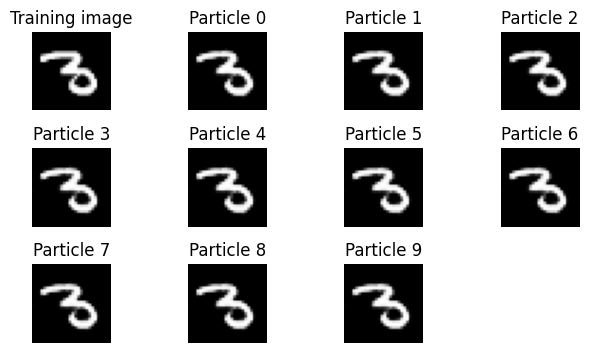

In [10]:
i, n_samples = 30, 10
samples = model.decode_posterior_samples(n_samples=n_samples, index=i)
names = ['Training image'] + [f'Particle {i}' for i in range(n_samples)]
plot_images(tf.concat([x[[i], ...], samples], axis=0), names)

## Recovering images corrupted with noise

In [11]:
#@title Definition of corrupt()

def corrupt(images: tf.Tensor, noise_intensity: float = 0.3):
    images += noise_intensity * 255 * tf.random.normal(shape=images.shape)
    images *= 1 + noise_intensity * (tf.random.uniform(shape=images.shape) - 0.5)
    return tf.minimum(tf.maximum(images, 0), 255)

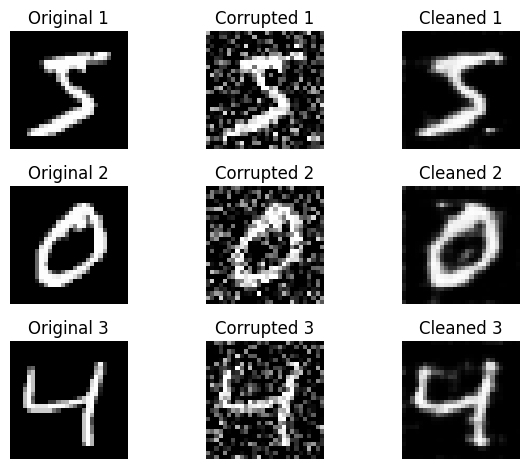

In [12]:
n_images = 3
images = x[:n_images, ...]
corrupted = corrupt(images)
reconstructed = model(corrupted, n_steps=1000)
names = sum([[f'Original {i + 1}', f'Corrupted {i + 1}', f'Cleaned {i + 1}']
             for i in range(n_images)], [])
interweaved = tf.reshape(tf.stack([images, corrupted, reconstructed], axis=1),
                         (3 * n_images,) + images.shape[1:])
plot_images(interweaved, names)

## Generating fakes

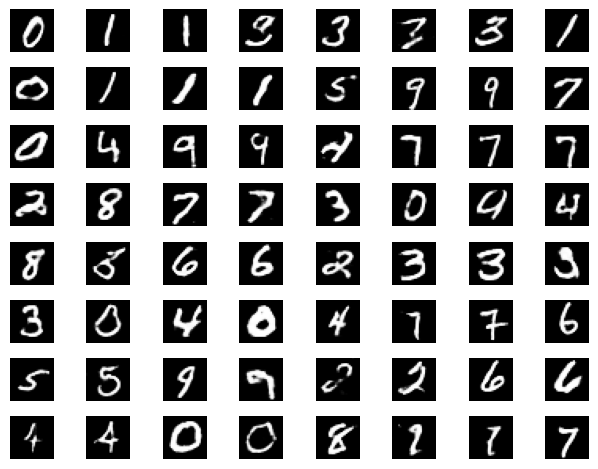

In [13]:
fakes = model.generate_fakes(n_fakes=64)
plot_images(fakes)

#Saving and loading the model

In [15]:
# Save:
#model.save('gdrive/MyDrive/model_ckpt/')
# Load:
#model = models.LangevinParticleAutoencoder.from_save('gdrive/MyDrive/model_ckpt/')